# Visual Odometry pipeline
A naive visual odometry implementation with OpenCV (for now), NumPy & Python

In [1]:
# Fetch data
!bash ../fetch_data.sh

### Run with KITTI
Make sure to download the KITTI odometry dataset and set KITTI=True

### Run with ad-hoc video
Set KITTI variable to False and input variable to the video

In [2]:
import cv2
import time
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
# Handrolled
from utils import display_mat, draw_points
from ransac import ransac
from features import extract_features
from geometry import triangulate, fundamentalToEssential, \
    extract_pose, normalize, FundamentalMatrixModel, integrate_pose, calculate_projection, create_normalization_matrix

## Parameters
- KITTI: Defines if the KITTI dataset should be used (requires download from kaggle or the KITTI website)
- input: If KITTI isn't used, this is the file to load for doing VO.
- max_corners: Maximum keypoints returned from goodFeatureToTrack.
- kernel_size: Size of the kernel to search for features with.
- quality: Corner detector "quality".
- ransac_minsamples: The number of samples used by RANSAC
- ransac_max_trial: maximum iteraions of the RANSAC search.
- ransac_residual_threshold: The residual threshold for ransac

In [3]:
# Script parameters
KITTI = True
KITTI_DATA_DIRECTORY = '/Users/haydenpennington/dev/data/kitti/'
input = '../videos/test_countryroad.mp4'
# input = 0
im_size = (640, 480)

# ORB Detector parameters
max_corners = 1500
kernel_size = 6
quality = 0.001
keypoint_size = 18

# Ransac parameters
ransac_minsamples = 8
ransac_max_trials = 150
ransac_residual_threshold = 0.001

# Pose extratction translation scaling
tscale = 1.0

# Point cloud clustering
n_points = 2
dbscan_eps = tscale * 0.5



In [4]:
seq = None
mono_folder = None
data_folder = None
train_image_names = None
train_labels = None

if KITTI == True:
    seq = '00'  
    mono_folder = 'image_2'
    data_root = KITTI_DATA_DIRECTORY
    data_folder = data_root + 'sequences/' + seq + '/' + mono_folder + '/'
    train_image_names = sorted([f for f in listdir(data_folder) if isfile(join(data_folder, f))])
    
    with open(data_root + 'poses/' + seq + '.txt', 'r') as f:
        train_labels = [x.split() for x in f.readlines()]
        train_labels = np.array([[float(x) for x in y] for y in train_labels])
        train_labels = train_labels.reshape(-1, 3, 4)

## Create the ORB feature detector
orb = cv2.ORB_create()
## Create the feature matcher
bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)


In [5]:
def match_frames(T, H, W, kps1, kps2, descriptors1, descriptors2):
    matches = bf_matcher.knnMatch(descriptors1, descriptors2, k=2)
    matches = np.asarray(matches)
    
    pairs = []
    norm_pairs = []
    indices = []

    for m,n in matches:
        # Check Lowe's ratio
        if m.distance < 0.75 * n.distance:
            pt1 = np.asarray(kps1[m.queryIdx].pt)
            pt2 = np.asarray(kps2[m.trainIdx].pt)
            pairs.append((pt1, pt2))
            pt1 = normalize(T, pt1)
            pt2 = normalize(T, pt2)
            norm_pairs.append((pt1, pt2))
            indices.append((m.queryIdx, m.trainIdx))

    pairs = np.asarray(pairs)
    norm_pairs = np.asarray(norm_pairs)

    # Filter with ransac
    if norm_pairs[:, 0].shape[0] >= ransac_minsamples and norm_pairs[:, 1].shape[0] >= ransac_minsamples:
        F, inliers = ransac(
            FundamentalMatrixModel(),
            norm_pairs,
            min_samples=ransac_minsamples,
            residual_threshold=ransac_residual_threshold,
            max_trials=ransac_max_trials
        )

        return norm_pairs[inliers], pairs[inliers], F, indices

    else:
        return None


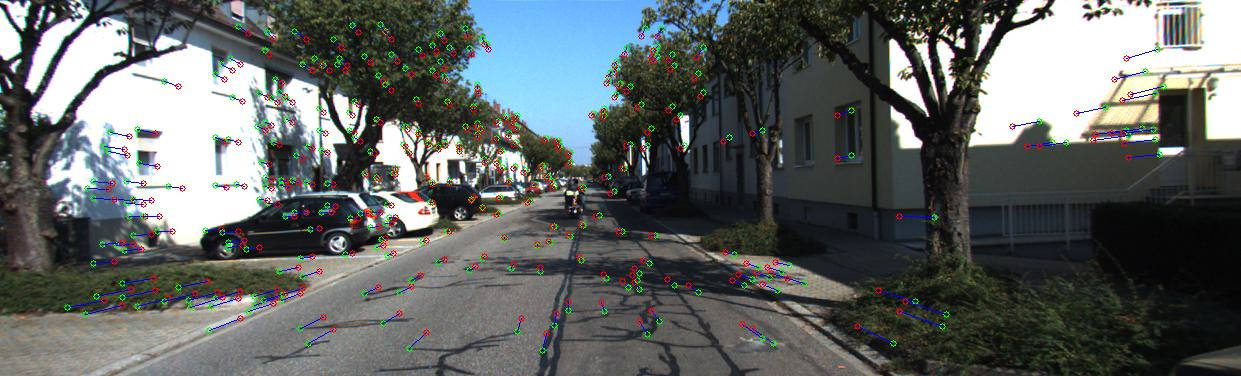

In [7]:
cap = None
if KITTI == False:
    cap = cv2.VideoCapture(input)

last = None
last_corners = None
last_kps = None
last_descriptors = None

R_abs = np.eye(3)
t_abs = np.zeros(3)
last_R = np.eye(3)
last_t = np.zeros(3)
t_abs_all = []
t_abs_gt = []
point_cloud = None
last_proj = None

i = 0
%matplotlib widget
while (KITTI == True and i < len(train_image_names)) or (cap is not None and cap.isOpened()):
    t0 = time.time()
    ret, im_original, label = None, None, None
    if KITTI == True:
        ret, im_original, label = True, cv2.imread(data_folder + train_image_names[i]), train_labels[i]
    else:
        ret, im_original = cap.read()

    if ret:
        im = im_original
        im = cv2.resize(im_original, im_size)
        multiplier_x = im_original.shape[1] / im.shape[1]
        multiplier_y = im_original.shape[0] / im.shape[0]
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        
        # Create the transformation matrix for normalization
        H, W = im.shape
        T = create_normalization_matrix(H, W)

        if last is not None:
            im1 = im
            im2 = last

            key_points1 = extract_features(im1, max_corners, quality, kernel_size, keypoint_size)
            kps, descriptors = orb.compute(im1, key_points1)

            H, W = im1.shape
            result = match_frames(T, H, W, kps, last_kps, descriptors, last_descriptors)

            if result is not None:
                norm_pairs, feature_pairs, F, indices = result

                try:
                    E = fundamentalToEssential(F)
                    R, t = extract_pose(E, norm_pairs[0, 0], norm_pairs[0, 1])
                    R_abs, t_abs = integrate_pose(R, R_abs, t, t_abs, tscale)
                    
                    t_abs_all.append(t_abs)
                    
                    if KITTI == True:
                        t_abs_gt.append(label[:3, 3])
                    
                    Rt = np.eye(4)
                    proj1 = Rt

                    if last_proj is not None:
                        proj1 = calculate_projection(R, t, last_proj)
                        kps1 = norm_pairs[:, 0]
                        kps2 = norm_pairs[:, 1]

                        # 4d homogeneous -> 3d
                        points4d = triangulate(proj1[:3, :4], last_proj[:3, :4], kps1, kps2, R, t)
                        points3d = (points4d / points4d[:, 3:])[:, :3]

                        if point_cloud is None:
                            point_cloud = points3d.reshape(-1, 3)
                        else:
                            point_cloud = np.concatenate([point_cloud, points3d.reshape(-1, 3)]).reshape(-1, 3)
                    
                    last_proj = proj1

                    draw_points(im_original, feature_pairs, multiplier_x, multiplier_y)
                    
                except ValueError as error:
                    print('error', error)

        last = im
        if last_corners is None:
            keypoints = extract_features(im, max_corners, quality, kernel_size, keypoint_size)
            last_kps, last_descriptors = orb.compute(im, keypoints)
        else:
            # last_corners = corners
            last_kps, last_descriptors = kps, descriptors

        cv2.imshow('im1', im_original)
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            break

        if (i > 99 and i % 100 == 0) or (i > 0 and i < 11 and i % 10 == 0):
            display_mat(cv2.cvtColor(im_original, cv2.COLOR_BGR2RGB))

        t1 = time.time()
        t_delta = (t1 - t0)
        # print (1 / t_delta)
        i += 1

    else:
        break

cv2.destroyAllWindows()
cv2.waitKey(4)
if KITTI == False:
    cap.release()

### Save the point cloud for viewing in open3d

In [8]:
t_abs_all = np.array(t_abs_all).reshape(-1, 3)
if KITTI == True:
    t_abs_gt = np.array(t_abs_gt)

if point_cloud is not None:
    
    r = 0
    
    import open3d as o3d

    pcd = o3d.geometry.PointCloud()
    pcd.transform([
        [-1, 0,  0, 0],
        [ 0, 1,  0, 0],
        [ 0, 0, 1, 0],
        [ 0, 0,  0, 1]
    ])
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    ret = np.array(pcd.cluster_dbscan(eps=dbscan_eps, min_points=n_points))

    # print(ret.shape)
    print(point_cloud.shape)
    
    print(point_cloud[ret > 0].shape)
    print(t_abs_all.shape)
    # all_points = np.concatenate([point_cloud[ret > 0], t_abs_all, t_abs_gt])
    all_points = np.concatenate([point_cloud[ret > -1], t_abs_all])
    
    pcd.points = o3d.utility.Vector3dVector(all_points)

    red = [255, 0, 0]
    green = [0, 255, 0]
    blue = [0, 0, 255]
    purple = [255, 0, 255]
    orange = [255, 255, 0]
    color_palette = [red, orange, blue, purple]
    cluster_colors = {}

    for n in set(ret):
        cluster_colors[n] = color_palette[np.random.randint(len(color_palette))]

    colors = np.ndarray(all_points.shape)

    for i, color in enumerate(colors):
        colors[i] = cluster_colors[ret[i]]
    # colors[:point_cloud[ret>-1].shape[0]] = red
    colors[point_cloud[ret>-1].shape[0]:point_cloud[ret>-1].shape[0]+t_abs_all.shape[0]] = green
    # colors[point_cloud[ret>0].shape[0]+t_abs_all.shape[0]:] = blue
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # downpcd = pcd.voxel_down_sample(voxel_size=0.5)
    # ret = np.asarray(point_cloud).flatten()[ret]

    o3d.io.write_point_cloud("../pointcloud_clustered.pcd", pcd)
    # visualizer = o3d.JVisualizer()
    # visualizer.add_geometry(pcd)
    # visualizer.show()




(17685, 3)
(6147, 3)
(68, 3)


## Plot the 3d trajectory of the camera
### Red vs Green
Red is the ground truth pose and green is the predicted pose of the camera.

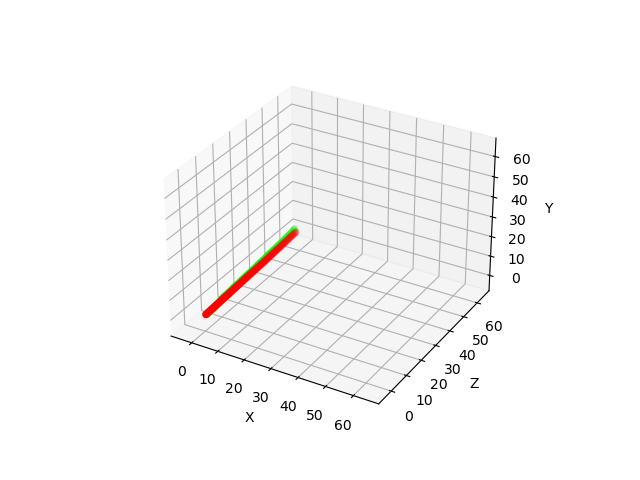

In [9]:
%matplotlib widget
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax2 = fig.add_subplot(projection='3d')
# pt = (t_abs_all[0, 0], t_abs_all[0, 1], t_abs_all[0, 2])
ax.scatter(t_abs_all[:, 0], t_abs_all[:, 2], t_abs_all[:, 1], color=[(0, 1, 0)])

maximum = None
minimum = None

if KITTI == True:
    ax.scatter(t_abs_gt[:, 0], t_abs_gt[:, 2], t_abs_gt[:, 1], color=(1, 0, 0))
    minimum = np.array(np.concatenate([t_abs_all, t_abs_gt])).min()
    maximum = np.array(np.concatenate([t_abs_all, t_abs_gt])).max()
else:
    minimum = np.array(t_abs_all).min()
    maximum = np.array(t_abs_all).max()
    
# ax.set_zscale(lower=minimum, upper=maxiumum, value=)
ax.set_xlim([minimum, maximum])
ax.set_ylim([minimum, maximum])
ax.set_zlim([minimum, maximum])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
# plt.plot(t_abs_all[:, 0], t_abs_all[:, 1], t_abs_all[:, 2])
plt.show()
